### Basic imports for the project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import zipfile
from PIL import Image
from moviepy.editor import ImageSequenceClip

from stable_baselines3.common.callbacks import BaseCallback

2023-05-05 13:13:45.347720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Imports that will emulate the game and an action space

In [2]:
import gym
import retro

### Imports for our PPO algorithm (Proximal Policy Optimization) and for pre-processing (grayscale and frame stacking)

In [3]:
from stable_baselines3 import PPO
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

### Using GPU for training (with AMD's ROCm), checking if we have access to Cuda (at least 4 times faster training)

In [4]:
import torch
torch.cuda.is_available()

True

### Hijacking the default action space with a wrapper that will allow us to
### create our own combos of buttons

In [5]:
combos = [
    [],
    ["RIGHT"],
    ["RIGHT","Y"],
    ["RIGHT","A"],
    ["RIGHT","Y","A"],
    ["RIGHT","Y","B"],
    ["LEFT","Y"],
    ["LEFT","Y","A"],
    ]

In [6]:
class Discretizer(gym.ActionWrapper):

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False]*env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)

        self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()


class MaRLioDiscretizer(Discretizer):

    def __init__(self, env):
        super().__init__(env=env, combos=combos)

### Storing the path of our custom data.json and scenario.json files into variables

In [7]:
data_path = "./data.json"
scenario_path = "./scenario.json"

### data.json will have memory addresses for things that we want to keep track of
### and will be accessed from the info variable once we run the environment
### scenario.json will be our way of calculating MaRLio's reward
### Let's see how they look like. 

### data.json

````
{
  "info": {
    "checkpoint": {
      "address": 5070,
      "type": "|i1"
    },
    "coins": {
      "address": 8261055,
      "type": "|u1"
    },
    "end_of_level": {
      "address": 8259846,
      "type": "|i1"
    },
    "lives": {
      "address": 8261054,
      "type": "|i1"
    },
    "powerups": {
      "address": 25,
      "type": "|i1"
    },
    "score": {
      "address": 8261428,
      "type": "<u4"
    },
    "xpos": {
      "address": 148,
      "type": "<u2"
    },
    "ypos": {
      "address": 114,
      "type": "<u4"
    },
    "yoshi_coins": {
      "address": 8262690,
      "type": "<u4"
    }
  }
}
````

### scenario.json

````
{
  "crop": [
    0,
    0,
    0,
    0
  ],
  "done": {
    "variables": {
      "lives": {
        "op": "equal",
        "reference": -1
      }
    }
  },
  "reward": {
    "variables": {
      "score": {
        "reward": 1.0
      },
      "coins": {
        "reward": 1.0
      },
      "yoshi_coins": {
        "reward": 1.0
      },
      "xpos": {
        "op": "greater",
        "reference": "last",
        "reward": 10
      },
      "ypos": {
        "op": "less",
        "reference": "last",
        "reward": 10
      },
      "xpos": {
        "op": "less",
        "reference": "last",
        "penalty": 0.1
      },
      "lives": {
        "op": "less",
        "reference": "last",
        "penalty": 1000.0
      },
      "end_of_level": {
        "op": "equal",
        "reference": 1,
        "reward": 1000000.0
      }
    }
  }
}
````

### Let's load our game, Super Mario World (SMW) from the Super Nintendo Entertainment System (SNES)
### using scenario and info kwargs, we can load our custom data.json and scenario.json
### using record kwarg, we can save the training sessions for future viewing

In [8]:
# saves recording to ./recordings/train/

# env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland1", record="./recordings/train/", scenario=scenario_path, info=data_path)

In [9]:
# saves recording to ./recordings/pred/

env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland2", record="./recordings/pred/", scenario=scenario_path, info=data_path)

In [10]:
# for video only, no recording

# env = retro.make(game="SuperMarioWorld-Snes", state="YoshiIsland1", scenario=scenario_path, info=data_path)

### This is where we wrap the environment in our own action space

In [11]:
disc_env = MaRLioDiscretizer(env)

In [12]:
obs = disc_env.reset()

### Let's check the index it returns and what combo we get from it

In [13]:
action = disc_env.action_space.sample()
print(action)
combos[action]

0


[]

### Now we can use that action inside our environment, one frame at a time
### and we can use tuple unpacking, to get access to some important information about our environment

In [14]:
obs, reward, terminated, info = disc_env.step(action)
print(f"score: {reward}\nterminated: {terminated}\ninfo: {info}")

score: 0.0
terminated: False
info: {'end_of_level': 0, 'lives': 4, 'powerups': 0, 'score': 0, 'coins': 0, 'ypos': 159, 'yoshi_coins': 0, 'xpos': 16, 'checkpoint': 0}


### The image we get is a 3-dimensional tensor with a height of 224 pixels, a width of 256 pixels, and 3 color channels (RGB)

In [15]:
obs.shape

(224, 256, 3)

### Let's visualize that frame

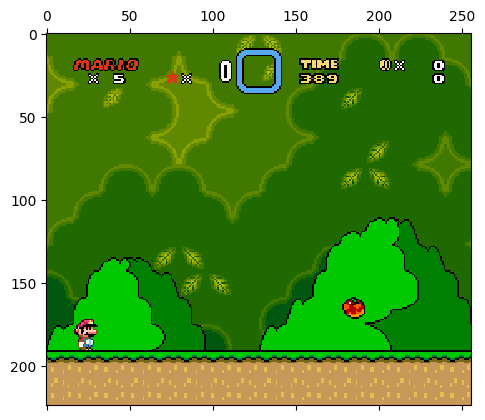

In [16]:
plt.matshow(obs)

### Let's look at Mario doing random actions

In [17]:
# state = disc_env.reset()

# done = False
# for _ in range(1000):
#     action = disc_env.action_space.sample()
#     state, reward, done, info = disc_env.step(action)
#     disc_env.render()
#     time.sleep(0.005)
# disc_env.render(close=True)

### Let's pre-process our images
### First, grayscale. that'll reduce the size of our environment by 66%
### Second, let's vectorize everything
### Third, let's stack 4 frames, our model will get a sense of momentum
### Normalize the pixels, between 0-1 instead of 0-255

In [18]:
disc_env = GrayScaleObservation(disc_env, keep_dim=True)
disc_env = DummyVecEnv([lambda:disc_env])
disc_env = VecFrameStack(disc_env, 4, channels_order="last")

In [19]:
state = disc_env.reset()

### Let's look at a frame (grayscale)

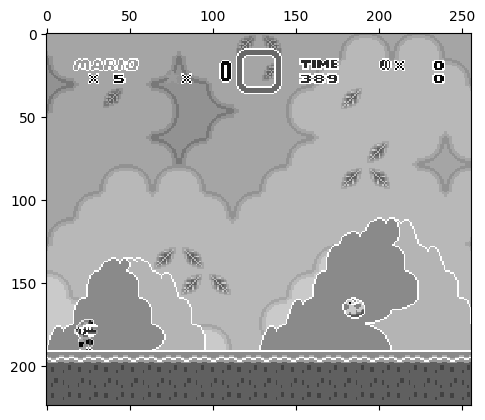

In [20]:
plt.matshow(state[0])

### This time, the (1, 224, 256, 4) shape indicates that the observation is a stack of 4 frames, 
### where each frame is a "color" (grayscale, 1 RGB channel) image with a resolution of 224x256 pixels.

In [21]:
state.shape

(1, 224, 256, 4)

### Taking 4 steps, so we don't have blank frames

In [22]:
for _ in range(3):
    state, reward, done, info = disc_env.step([disc_env.action_space.sample()])

### Let's visualize our stack of frames, with random actions from our list of combos
### We should see some movement

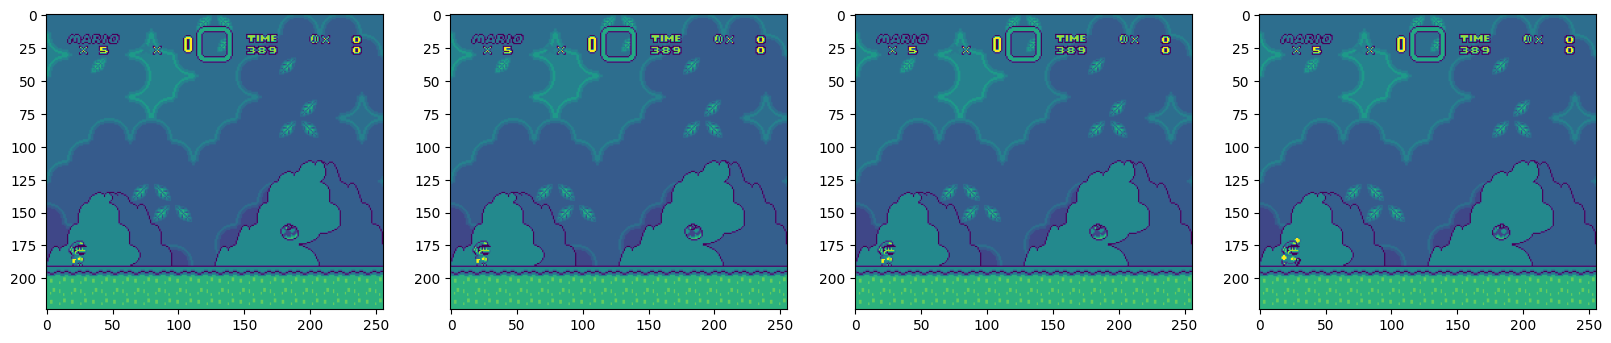

In [23]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [24]:
state = disc_env.reset()

### Defining a class that will create our logs and save our model at every check_freq

In [25]:
# callback helper function

# logs and model saving
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)

        return True

### Creating variables that points to our paths for saving the model and the logs (tensorboard)

In [26]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

#### Proximal Policy Optimization (PPO) is a reinforcement learning algorithm that is used to optimize policies for continuous control problems.  
#### The PPO algorithm uses a surrogate objective function to update the policy parameters in an iterative manner.  

#### The formula for the PPO objective function is as follows:

    LCLIP(θ) = E[min(r(θ)A, clip(r(θ), 1 - ε, 1 + ε)A)]

#### Where:

    θ represents the policy parameters
    r(θ) represents the ratio of the probabilities of taking the action under the new policy and the old policy
    A represents the advantage function, which estimates how much better a particular action is compared to the average action
    ε is a hyperparameter that determines the degree of clipping that is applied to the ratio r(θ)

#### The PPO algorithm maximizes this objective function by updating the policy parameters using stochastic gradient ascent.  
#### In addition, the algorithm includes an entropy bonus term to encourage exploration and prevent the policy from becoming too deterministic.

![Alt text](ppo.png)

### Keeping track of some hyperparameters for finetuning

In [27]:
check_freq = 1_000_000
total_timesteps = 10_000_000

learning_rate = 0.0000001
n_steps = 512
clip_range = 0.2
ent_coef = 0.1

### Instance of our PPO algorithm, with the rest of the hyperparameters set to default

In [28]:
callback = TrainAndLoggingCallback(check_freq=check_freq, save_path=CHECKPOINT_DIR)

In [ ]:
model = PPO(
    "CnnPolicy", 
    disc_env, 
    learning_rate=learning_rate, 
    n_steps=n_steps, 
    batch_size=64, 
    n_epochs=10, 
    gamma=0.99, 
    gae_lambda=0.95, 
    clip_range=clip_range, 
    clip_range_vf=None, 
    normalize_advantage=True, 
    ent_coef=ent_coef, 
    vf_coef=0.5, 
    max_grad_norm=0.5, 
    use_sde=False, 
    sde_sample_freq=-1, 
    target_kl=None,  
    tensorboard_log=LOG_DIR, 
    policy_kwargs=None, 
    verbose=0, 
    seed=42, 
    device="auto", 
    _init_setup_model=True
    )

### This is where MaRLio starts his adventure (training)

In [ ]:
model.learn(
    total_timesteps=total_timesteps, 
    progress_bar=True, 
    tb_log_name="PPO",
    callback=[
    callback
    ]
)

### Let's add a powerup dictionnary, we will see what powerups MaRLio has

In [29]:
powerup_dict = {
    0: "small",
    1: "big",
    2: "cape",
    3: "fire"
}

### Let's add a dictionnary of our overlays

In [30]:
combo_images = {
    0: "./controller/blank.png",
    1: "./controller/right.png",
    2: "./controller/righty.png",
    3: "./controller/righta.png",
    4: "./controller/rightya.png",
    5: "./controller/rightyb.png",
    6: "./controller/lefty.png",
    7: "./controller/leftya.png",
    8: "./controller/leftyb.png",
    9: "./controller/a.png",
    10: "./controller/b.png"
}

### Let's load the models and predict the environment with the models' knowledge

In [31]:
# game loop for predict

def pred(model):
    total_reward = 0
    action_dict = {}
    powerup = ""
    check = False
    frame = 1

    state = disc_env.reset()
    done = False
    while not done:
        action, _ = model.predict(state)

        action_dict[frame] = action[0]
        state, reward, done, info = disc_env.step(action)

        if info[0]["powerups"] != powerup:
            powerup = info[0]["powerups"]
            print(powerup_dict.get(powerup, "Invalid integer value"))

        if info[0]["checkpoint"] == 1 and not check:
            check = True
            print("Midlevel Checkpoint Reached: +50k reward")

        if info[0]["end_of_level"] == 1:
            print("End of level Reached: +100k reward")

        frame += 1

        total_reward += reward
        disc_env.render()
        time.sleep(0.005)

    print("Total reward:", total_reward[0])
    print()
    return action_dict

### Helper function that will convert our .bk2 to .mp4

In [32]:
def bk2_to_mp4():
    bk2_files = [f for f in os.listdir("./recordings/pred/") if f.endswith(".bk2")]
    bk2_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    for bk2_file in bk2_files:
        with zipfile.ZipFile(f"./recordings/pred/{bk2_file}", "r") as zip_file:
            content = zip_file.read("Input Log.txt").decode("utf-8")
            size = zip_file.getinfo("Input Log.txt").file_size
        if not any(key in content for key in [
            "|..|.....B......|",
            "|..|....YB...R..|",
            "|..|..........A.|",
            "|..|.........R..|",
            "|..|....YB..L...|",
            "|..|........L...|",
            "|..|....YB...R..|",
            "|..|.........RA.|",
            "|..|....Y...L...|",
            "|..|....Y...L.A.|"
            ]) or size<1024:
            os.remove(os.path.join("./recordings/pred/", bk2_file))
            print(f"The file {bk2_file} (input log size {size}) has been deleted.")
        else:
            print(f"The file {bk2_file} contains key presses.")
            mp4_file = bk2_file.split(".")[0] + ".mp4"
            print(f"converting {bk2_file} into .mp4")
            print()
            command = f"python3.8 -m retro.scripts.playback_movie ./recordings/pred/{bk2_file}"
            move = f"mv ./recordings/pred/{mp4_file} ./recordings/pred/videos/"
            os.system(command)
            print(f"moving {mp4_file} to video folder: ./recordings/pred/videos/")
            print()
            os.system(move)

### Helper function that will create an overlay video

In [33]:
def generate_video(combo_images, action_dict, filename, fps):
    print(f"Generating a video of the overlay for {filename}")
    images = []
    for _, action_index in action_dict.items():
        image_path = combo_images[action_index]
        with Image.open(image_path) as image:
            images.append(np.array(image))
    clip = ImageSequenceClip(images, fps=fps)
    clip = clip.set_duration(len(action_dict) / fps)
    clip = clip.set_position(('center', 'center'))
    clip.write_videofile(filename, fps=fps, codec='mpeg4')
    print()

### Our main function that will call our helper functions in turn, automating the process of generating files

In [34]:
def automate():
    models = [f for f in os.listdir("./train/") if f.endswith(".zip")]
    models.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for model in models:
        marlio = f"{model}"
        model = PPO.load(f"./train/{marlio}")
        print(f"using {marlio}")
        print()

        action_dict = pred(model)
        filename = "./overlays/" + marlio.split(".")[0] + ".mp4"
        generate_video(combo_images, action_dict, filename, 60)
    bk2_to_mp4()

### Let's automate the boring stuff!

In [35]:
automate()

using best_model_1000000.zip

small
big
Midlevel Checkpoint Reached: +50k reward
End of level Reached: +100k reward
Total reward: 185127.0

Generating a video of the overlay for ./overlays/best_model_1000000.mp4
Moviepy - Building video ./overlays/best_model_1000000.mp4.
Moviepy - Writing video ./overlays/best_model_1000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_1000000.mp4

using best_model_2000000.zip

small
End of level Reached: +100k reward
Total reward: 265196.0

Generating a video of the overlay for ./overlays/best_model_2000000.mp4
Moviepy - Building video ./overlays/best_model_2000000.mp4.
Moviepy - Writing video ./overlays/best_model_2000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_2000000.mp4

using best_model_3000000.zip

small
Total reward: -728.0

Generating a video of the overlay for ./overlays/best_model_3000000.mp4
Moviepy - Building video ./overlays/best_model_3000000.mp4.
Moviepy - Writing video ./overlays/best_model_3000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_3000000.mp4

using best_model_4000000.zip

small
Total reward: 27573.0

Generating a video of the overlay for ./overlays/best_model_4000000.mp4
Moviepy - Building video ./overlays/best_model_4000000.mp4.
Moviepy - Writing video ./overlays/best_model_4000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_4000000.mp4

using best_model_5000000.zip

small
End of level Reached: +100k reward
Total reward: 542852.0

Generating a video of the overlay for ./overlays/best_model_5000000.mp4
Moviepy - Building video ./overlays/best_model_5000000.mp4.
Moviepy - Writing video ./overlays/best_model_5000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_5000000.mp4

using best_model_6000000.zip

small
Total reward: -262.0

Generating a video of the overlay for ./overlays/best_model_6000000.mp4
Moviepy - Building video ./overlays/best_model_6000000.mp4.
Moviepy - Writing video ./overlays/best_model_6000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_6000000.mp4

using best_model_7000000.zip

small
End of level Reached: +100k reward
Total reward: 137173.0

Generating a video of the overlay for ./overlays/best_model_7000000.mp4
Moviepy - Building video ./overlays/best_model_7000000.mp4.
Moviepy - Writing video ./overlays/best_model_7000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_7000000.mp4

using best_model_8000000.zip

small
Total reward: 39793.0

Generating a video of the overlay for ./overlays/best_model_8000000.mp4
Moviepy - Building video ./overlays/best_model_8000000.mp4.
Moviepy - Writing video ./overlays/best_model_8000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_8000000.mp4

using best_model_9000000.zip

small
Total reward: 43413.0

Generating a video of the overlay for ./overlays/best_model_9000000.mp4
Moviepy - Building video ./overlays/best_model_9000000.mp4.
Moviepy - Writing video ./overlays/best_model_9000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_9000000.mp4

using best_model_10000000.zip

small
big
Midlevel Checkpoint Reached: +50k reward
small
Total reward: 119516.0

Generating a video of the overlay for ./overlays/best_model_10000000.mp4
Moviepy - Building video ./overlays/best_model_10000000.mp4.
Moviepy - Writing video ./overlays/best_model_10000000.mp4



Moviepy - Done !
Moviepy - video ready ./overlays/best_model_10000000.mp4

The file SuperMarioWorld-Snes-YoshiIsland2-000000.bk2 (input log size 133) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000001.bk2 (input log size 169) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000002.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000003.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000003.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000003.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000004.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000005.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000005.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000005.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000006.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000007.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000007.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000007.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000008.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000009.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000009.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000009.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000010.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000011.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000011.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000011.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000012.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000013.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000013.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000013.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000014.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000015.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000015.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000015.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000016.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000017.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000017.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000017.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000018.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000019.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000019.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000019.mp4 to video folder: ./recordings/pred/videos/

The file SuperMarioWorld-Snes-YoshiIsland2-000020.bk2 (input log size 115) has been deleted.
The file SuperMarioWorld-Snes-YoshiIsland2-000021.bk2 contains key presses.
converting SuperMarioWorld-Snes-YoshiIsland2-000021.bk2 into .mp4



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

moving SuperMarioWorld-Snes-YoshiIsland2-000021.mp4 to video folder: ./recordings/pred/videos/



frame=52758 fps=1318 q=-1.0 Lsize=   25045kB time=00:14:37.80 bitrate= 233.7kbits/s speed=21.9x    
video:9538kB audio:14559kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.930073%
[libx264 @ 0x5590e895f7c0] frame I:219   Avg QP:12.14  size: 16284
[libx264 @ 0x5590e895f7c0] frame P:20343 Avg QP:16.90  size:   244
[libx264 @ 0x5590e895f7c0] frame B:32196 Avg QP:22.98  size:    38
[libx264 @ 0x5590e895f7c0] consecutive B-frames: 13.8% 12.0%  7.9% 66.3%
[libx264 @ 0x5590e895f7c0] mb I  I16..4: 11.2% 17.6% 71.2%
[libx264 @ 0x5590e895f7c0] mb P  I16..4:  0.2%  0.2%  0.2%  P16..4:  4.1%  1.8%  0.9%  0.0%  0.0%    skip:92.6%
[libx264 @ 0x5590e895f7c0] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  2.4%  0.5%  0.1%  direct: 0.2%  skip:96.8%  L0:50.1% L1:47.8% BI: 2.0%
[libx264 @ 0x5590e895f7c0] 8x8 transform intra:24.1% inter:20.7%
[libx264 @ 0x5590e895f7c0] direct mvs  spatial:41.3% temporal:58.7%
[libx264 @ 0x5590e895f7c0] coded y,uvDC,uvAC intra: 40.5% 68.3% 63.7% inter: 0

### Tensorboard for troubleshooting

In [36]:
%load_ext tensorboard

: 